# Train a Regression Model

In this notebook we will train a Linear Regression Model on the Green Taxi Dataset. We will only use one month for the training. And keep only a small number of features. 

We want the model to predict the duration of a trip. This can be useful for the taxi drivers to plan their trips, for the customers to know how long a trip will take but also for the taxi companies to plan their fleet. The first two predictions would need real time predictions because the duration of a trip is not known in advance. The last one could be done in batch mode, as it is more a analytical task that doesn't need to be done in real time.

Additionally, we will use MLFlow to track the model training and log the model artifacts.

In [1]:
import os
from dotenv import load_dotenv

import pandas as pd

import mlflow
from mlflow.tracking.client import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#import randomforest regressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [2]:
year = 2021
month = 1
color = "green"

In [3]:
# Download the data
if not os.path.exists(f"./data/{color}_tripdata_{year}-{month:02d}.parquet"):
    os.system(f"wget -P ./data https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year}-{month:02d}.parquet")

--2023-07-20 10:03:20--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
Auflösen des Hostnamens d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)… 2600:9000:2070:6a00:b:20a5:b140:21, 2600:9000:2070:5400:b:20a5:b140:21, 2600:9000:2070:d800:b:20a5:b140:21, ...
Verbindungsaufbau zu d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|2600:9000:2070:6a00:b:20a5:b140:21|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 1333519 (1,3M) [binary/octet-stream]
Wird in »./data/green_tripdata_2021-01.parquet« gespeichert.

     0K .......... .......... .......... .......... ..........  3% 2,49M 0s
    50K .......... .......... .......... .......... ..........  7% 2,43M 0s
   100K .......... .......... .......... .......... .......... 11% 4,12M 0s
   150K .......... .......... .......... .......... .......... 15% 3,70M 0s
   200K .......... .......... .......... .......... .......... 19% 9,70M 0s
   250K .....

In [4]:
# Load the data

df = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")

In [5]:
df.shape

(76518, 20)

Now we will set up the connection to MLFlow. For that we have to create a `.env` file with the URI to the MLFlow Server in gcp (this will be `http://<external-ip>:5000`). You can simply run:

```bash
echo "MLFLOW_TRACKING_URI=http://<external-ip>:5000" > .env
```

We also will create an experiment to track the model and the metrics.

In [6]:
load_dotenv()

MLFLOW_TRACKING_URI=os.getenv("MLFLOW_TRACKING_URI")

In [7]:
# Set up the connection to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
# Setup the MLflow experiment 
mlflow.set_experiment("green-taxi-monitoring")

2023/07/20 10:04:22 INFO mlflow.tracking.fluent: Experiment with name 'green-taxi-monitoring' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://mlflow-artifacts-cjh/default/6', creation_time=1689840262676, experiment_id='6', last_update_time=1689840262676, lifecycle_stage='active', name='green-taxi-monitoring', tags={}>

If everything went well, you should be able to see the experiment now in the MLFlow UI at `http://<external-ip>:5000`.

Let's start now with looking at the data a bit:

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [10]:
# Look for missing values
df.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       36047
RatecodeID               36047
PULocationID                 0
DOLocationID                 0
passenger_count          36047
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                76518
improvement_surcharge        0
total_amount                 0
payment_type             36047
trip_type                36047
congestion_surcharge     36047
dtype: int64

Nearly all features seem to be in the correct type and we have only missings in features that we will not use for the model training. For predicting the duration of a trip, we will use the following features:

- `PULocationID`: The pickup location ID
- `DOLocationID`: The dropoff location ID
- `trip_distance`: The distance of the trip in miles
- `fare_amount`: The fare amount in USD
- `total_amount`: The total amount in USD
- `passenger_count`: The number of passengers

But first we have to calculate the duration of the trip in minutes because it is our target. For that we will use the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns. We will also remove all trips that have a duration of 0 and that are longer than 1 hours to remove outliers.

In [11]:
features = ["PULocationID", "DOLocationID", "trip_distance", "passenger_count", "fare_amount", "total_amount"]
target = 'duration'

In [12]:
# calculate the trip duration in minutes and drop trips that are less than 1 minute and more than 2 hours
def calculate_trip_duration_in_minutes(df):
    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds() / 60
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 8)]
    df = df[features + [target]]
    return df
    

In [13]:
df_processed = calculate_trip_duration_in_minutes(df)

In [14]:
df_processed.head()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,total_amount,duration
0,43,151,1.01,1.0,5.5,6.80,3.933333
1,166,239,2.53,1.0,10.0,16.86,8.750000
2,41,42,1.12,1.0,6.0,8.30,5.966667
3,168,75,1.99,1.0,8.0,9.30,7.083333
7,75,75,0.45,6.0,3.5,5.76,2.316667


In [15]:
df_processed.duration.describe()

count    38065.000000
mean        13.694301
std         10.404338
min          1.000000
25%          6.650000
50%         10.716667
75%         17.233333
max         59.983333
Name: duration, dtype: float64

<Axes: >

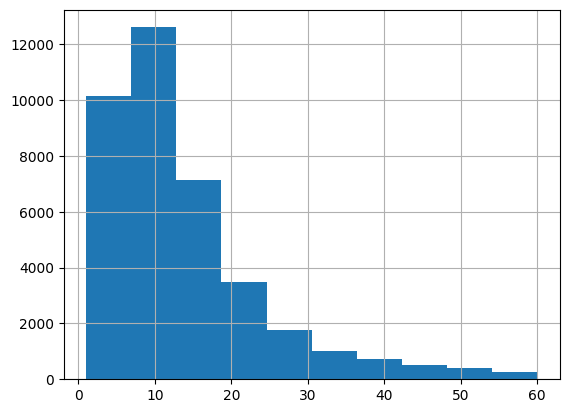

In [16]:
df_processed.duration.hist()

Now that we have the dataframe that we want to train our model on. We need to split it into a train and test set. We will use 80% of the data for training and 20% for testing.

In [17]:
y=df_processed["duration"]
X=df_processed.drop(columns=["duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

And now we can train the model and track the experiment with MLFlow. We will set tags to the experiment to make it easier to find it later.

- `model`: `linear-regression`
- `dataset`: `yellow-taxi`
- `developer`: `your-name`
- `train_size`: The size of the train set
- `test_size`: The size of the test set
- `features`: The features that we used for training
- `target`: The target that we want to predict
- `year`: The year of the data
- `month`: The month of the data

We could also log the model parameters but Linear Regression doesn't have any.

And finally we will log the metrics:

- `rmse`: The root mean squared error

We will also log the model artifacts. For that we will need to set the `service account json` that we downloaded earlier as the environment variable `GOOGLE_APPLICATION_CREDENTIALS`. 

In [18]:
load_dotenv()
SA_KEY= os.getenv("SA_KEY")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SA_KEY

In [19]:
with mlflow.start_run():
    
    tags = {
        "model": "linear regression",
        "developer": "<your name>",
        "dataset": f"{color}-taxi",
        "year": year,
        "month": month,
        "features": features,
        "target": target
    }
    mlflow.set_tags(tags)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.sklearn.log_model(lr, "model")
    run_id = mlflow.active_run().info.run_id

    model_uri = f"runs:/{run_id}/model"
    model_name = "green-taxi-ride-duration"
    mlflow.register_model(model_uri=model_uri, name=model_name)

    model_version = 1
    new_stage = "Production"
    client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

Successfully registered model 'green-taxi-ride-duration'.
2023/07/20 10:05:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: green-taxi-ride-duration, version 1
Created version '1' of model 'green-taxi-ride-duration'.


You should now see your run in the MLFlow UI. Under the created experiment. You can also see the logged tags, the metric and the saved model.

![mlflow-ui](./images/mlflow-run.png)

And you can see what you need to do to load the model in an API or script in the UI as long as the application has access to MLFlow.


# Retrain the model - my addition

In [1]:
import os
from dotenv import load_dotenv

import pandas as pd

import mlflow
from mlflow.tracking.client import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#import randomforest regressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
year = 2022
month = 2
color = "green"

In [3]:
# Download the data
if not os.path.exists(f"./data/{color}_tripdata_{year}-{month:02d}.parquet"):
    os.system(f"wget -P ./data https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year}-{month:02d}.parquet")

In [6]:
# Load the data

df = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")

# Add the old dataset together with this new one

df2 = pd.read_parquet(f"./data/green_tripdata_2021-01.parquet")


pd.concat([df, df2], ignore_index=True)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-02-01 00:20:21,2022-02-01 00:24:30,N,1.0,43,238,1.0,1.16,5.50,0.50,0.5,1.02,0.00,None,0.3,7.82,1.0,1.0,0.00
1,2,2022-02-01 00:32:26,2022-02-01 00:35:31,N,1.0,166,24,1.0,0.57,4.50,0.50,0.5,0.00,0.00,None,0.3,5.80,2.0,1.0,0.00
2,1,2022-02-01 00:17:27,2022-02-01 00:44:44,N,1.0,226,219,1.0,0.00,42.20,0.00,0.5,0.00,0.00,None,0.3,43.00,1.0,1.0,0.00
3,2,2022-02-01 00:45:37,2022-02-01 01:27:16,N,1.0,89,83,1.0,16.62,49.00,0.50,0.5,0.00,0.00,None,0.3,50.30,2.0,1.0,0.00
4,2,2022-02-01 00:06:46,2022-02-01 00:30:06,N,1.0,7,238,1.0,5.97,21.00,0.50,0.5,4.50,0.00,None,0.3,29.55,1.0,1.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145912,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
145913,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
145914,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
145915,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [7]:

load_dotenv()
MLFLOW_TRACKING_URI=os.getenv("MLFLOW_TRACKING_URI")
# Set up the connection to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
# Setup the MLflow experiment 
mlflow.set_experiment("green-taxi-monitoring")
features = ["PULocationID", "DOLocationID", "trip_distance", "passenger_count", "fare_amount", "total_amount"]
target = 'duration'
# calculate the trip duration in minutes and drop trips that are less than 1 minute and more than 2 hours
def calculate_trip_duration_in_minutes(df):
    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds() / 60
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 8)]
    df = df[features + [target]]
    return df
    
df_processed = calculate_trip_duration_in_minutes(df)
y=df_processed["duration"]
X=df_processed.drop(columns=["duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
load_dotenv()
SA_KEY= os.getenv("SA_KEY")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SA_KEY


In [10]:
latest_versions = client.get_latest_versions("green-taxi-ride-duration")
latest_versions[0].version

'1'

In [17]:

with mlflow.start_run():
    
    tags = {
        "model": "linear regression",
        "developer": "chris-hedemann",
        "dataset": f"{color}-taxi",
        "year": year,
        "month": month,
        "features": features,
        "target": target
    }
    mlflow.set_tags(tags)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.sklearn.log_model(lr, "model")
    run_id = mlflow.active_run().info.run_id

    model_uri = f"runs:/{run_id}/model"
    model_name = "green-taxi-ride-duration"
    mlflow.register_model(model_uri=model_uri, name=model_name)

    ## Added code to update the latest version to Production
    latest_versions = client.get_latest_versions(model_name)
    model_version = int(latest_versions[-1].version)
    new_stage = "Production"
    client.transition_model_version_stage(
        name=model_name,
        version=model_version,
        stage=new_stage,
        archive_existing_versions=True
    )

/Users/bromethius/neuefische/mle-monitoring-in-ml/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/bromethius/neuefische/mle-monitoring-in-ml/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'green-taxi-ride-duration' already exists. Creating a new version of this model...
2023/07/20 11:37:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: green

## Now change the reference data!

In [19]:
y_pred_train = lr.predict(X_train)

train_data = X_train.copy()
train_data["duration"] = y_train
train_data["prediction"] = y_pred_train
train_data.to_parquet("./data/reference_data.parquet")

In [20]:
int(latest_versions[-1].version)

5